<a href="https://colab.research.google.com/github/ashutosh8021/Open-source-Practice/blob/main/Marine_Species_Classifier_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/marine_species"


Streaming output truncated to the last 5000 lines.
  inflating: /content/marine_species/Fish_Data/images/numbered/463.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/464.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/465.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/466.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/467.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/468.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/469.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/47.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/470.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/471.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/472.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/473.png  
  inflating: /content/marine_species/Fish_Data/images/numbered/474.png  
 

In [ ]:
import os
from collections import Counter

data_dir = '/content/marine_species/Fish_Data/images/cropped'
files = os.listdir(data_dir)

species_names = [f.rsplit('_', 1)[0] for f in files if f.endswith('.png')]


species_counts = Counter(species_names)

print("Species and their image counts:\n")
for species, count in species_counts.items():
    print(f"{species}: {count} images")


Species and their image counts:

epinephelus_latifasciatus: 7 images
wetmorella_nigropinnata: 12 images
monotaxis_grandoculis: 22 images
nemipterus_furcosus: 10 images
variola_louti: 16 images
Istiophorus_platypterus: 6 images
halichoeres_melanurus: 23 images
plectropomus_laevis: 15 images
thalassoma_purpureum: 17 images
lutjanus_carponotatus: 15 images
bodianus_vulpinus: 6 images
halichoeres_hortulanus: 19 images
bodianus_bilunulatus: 17 images
pteragogus_enneacanthus: 8 images
herklotsichthys_quadrimaculatus: 6 images
pseudocaranx_dentex: 11 images
epinephelus_ongus: 16 images
P1ROZC-Z: 17 images
ophthalmolepis_lineolatus: 10 images
scomberoides_commersonnianus: 7 images
valamugil_cunnesius: 4 images
novaculoides_macrolepidotus: 10 images
aethaloperca_rogaa: 11 images
thalassoma_jansenii: 11 images
choerodon_schoenleinii: 11 images
amanses_scopas: 19 images
pteragogus_flagellifer: 5 images
choerodon_fasciatus: 19 images
anampses_melanurus: 7 images
labroides_dimidiatus: 18 images
epi

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = '/content/marine_species/Fish_Data/images/cropped'
output_dir = '/content/marine_species/split_data'
os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
species_to_files = {}

for f in image_files:
    species = f.rsplit('_', 1)[0]
    species_to_files.setdefault(species, []).append(f)

# Split and copy
for species, files in species_to_files.items():
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    for split, split_files in [('train', train_files), ('test', test_files)]:
        split_dir = os.path.join(output_dir, split, species)
        os.makedirs(split_dir, exist_ok=True)
        for f in split_files:
            shutil.copy(os.path.join(data_dir, f), os.path.join(split_dir, f))


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset
train_data = ImageFolder(root=os.path.join(output_dir, 'train'), transform=transform)
test_data = ImageFolder(root=os.path.join(output_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Simple CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = CNN(num_classes=len(train_data.classes))


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 643.1921
Epoch 2, Loss: 592.0382
Epoch 3, Loss: 514.9322
Epoch 4, Loss: 398.5774
Epoch 5, Loss: 273.2051


In [ ]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_data.classes))


                                 precision    recall  f1-score   support

                       A73EGS-P       0.00      0.00      0.00         2
                       CUNWCB-Y       0.50      0.50      0.50         2
        Istiophorus_platypterus       0.00      0.00      0.00         2
                       P1ROZC-Z       1.00      0.25      0.40         4
                       PQV7DP-S       0.00      0.00      0.00         2
         acanthaluteres_brownii       0.00      0.00      0.00         1
  acanthaluteres_spilomelanurus       0.00      0.00      0.00         1
        acanthaluteres_vittiger       0.00      0.00      0.00         2
           acanthistius_cinctus       0.33      0.50      0.40         2
        acanthopagrus_australis       0.00      0.00      0.00         2
            acanthopagrus_berda       0.50      0.67      0.57         3
            acanthopagrus_latus       0.00      0.00      0.00         1
             achoerodus_gouldii       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os

data_dir = '/content/marine_species/Fish_Data/images/cropped'
class_names = sorted(os.listdir(data_dir))


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, class_names, device):
    model.eval()
    images, labels = next(iter(dataloader))

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(pretrained=True)
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.3MB/s]


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
pip install torchcam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image


In [ ]:
import os

data_dir = "/content/marine_species/Fish_Data/images/cropped"
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 4415


In [ ]:
from torchvision.models import resnet18
import torch.nn as nn



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)



In [ ]:
import os
from torchvision import transforms
from PIL import Image

# Define the transform with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


data_dir = '/content/marine_species/Fish_Data/images/cropped'


image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]


if not image_files:
    raise FileNotFoundError(f"No .jpg images found in {data_dir}. Please check the directory.")

img_path = os.path.join(data_dir, image_files[0])
print(img_path)

img = Image.open(img_path).convert('RGB')

if img.mode == 'L':
    img = transforms.Grayscale(num_output_channels=3)(img)

input_tensor = transform(img).unsqueeze(0)

/content/marine_species/Fish_Data/images/cropped/gymnosarda_unicolor_2.jpg


!pip install torchcam


In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [ ]:
# Set up Grad-CAM on the last convolutional layer
cam_extractor = GradCAM(model, target_layer='layer4')

out = model(input_tensor)


class_idx = out.squeeze(0).argmax().item()
print(f"Predicted class: {class_names[class_idx]}")


Predicted class: bodianus_loxozonus_7.png


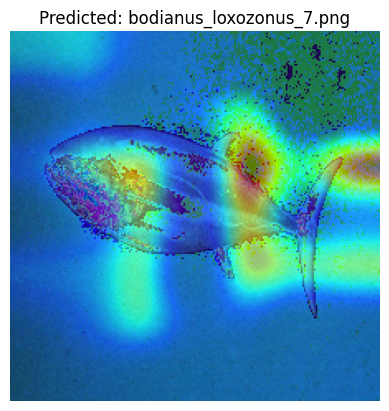

In [ ]:

activation_map = cam_extractor(class_idx, out)


result = overlay_mask(to_pil_image(input_tensor.squeeze().cpu()), to_pil_image(activation_map[0].squeeze().cpu(), mode='F'), alpha=0.5)


plt.imshow(result)
plt.title(f"Predicted: {class_names[class_idx]}")
plt.axis('off')
plt.show()


In [ ]:
result.save("gradcam_result.jpg")
print("Heatmap saved as gradcam_result.jpg")


Heatmap saved as gradcam_result.jpg


In [1]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.6 MB/s 

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
